# THE BATTLE OF NEIGHBORHOODS

# Introduction:

New York City's demographics show that it is a large and ethnically diverse metropolis. With it's diverse culture , comes diverse food items. There are many resturants in New york City, each beloning to different categories like Chinese , Indian , French etc.

So as part of this project , we will list and visualize all major parts of New York City that has great indian resturants.

# Data:

For this project we need the following data:
1. New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
2. Indian resturants in each neighborhood of new york city.
3. GeoSpace data

## Questions that will be answers at the end of this project :

### 1. What are best location in New York City for Indian Cuisine?
### 2. Which areas have potential Indian Restaurant Market?
### 3. Which all areas lack Indian Restaurants?
### 4. Which is the best place to stay if you prefer Indian Cuisine?

# Methodology:

1. We begin by collecting the New York city data from "https://cocl.us/new_york_dataset".
2. We will find all venues for each neighborhood using FourSquare API.
3. We will then filter out all Indian Restuarant venues.
4. Next using FourSquare API, we will find the Ratings, Tips, and Like count for all the Indian Resturants.
5. Next we will sort the data keeping Ratings as the constraint.
6. Finally, we will visualize the Ranking of neighborhoods using python's Folium library.

Lets Start by importing the required Libraries.

In [77]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
#!conda install -c conda-forge geocoder -y
import geocoder
import os
#!pip install folium
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [78]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [79]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '2NEJDJUXJX11KNIA2SVQ2G2HNSIW3VRGJR3SVNTUNKMHNOII' # your Foursquare ID
    CLIENT_SECRET = 'EI153WDVGMN3DYF3OHNXEDYIIPUXHPVUMU4EPSRMAKKTYSCU' # your Foursquare Secret
    VERSION = '20200401' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [80]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '2NEJDJUXJX11KNIA2SVQ2G2HNSIW3VRGJR3SVNTUNKMHNOII' # your Foursquare ID
    CLIENT_SECRET = 'EI153WDVGMN3DYF3OHNXEDYIIPUXHPVUMU4EPSRMAKKTYSCU' # your Foursquare Secret
    VERSION = '20200401' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [81]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [82]:
new_york_data=get_new_york_data()

In [83]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [84]:
new_york_data.shape

(306, 4)

### The above result shows that there are 306 different Neighborhoods in New York.

Now let create a BAR PLOT to show different Neighborhoods in New York.

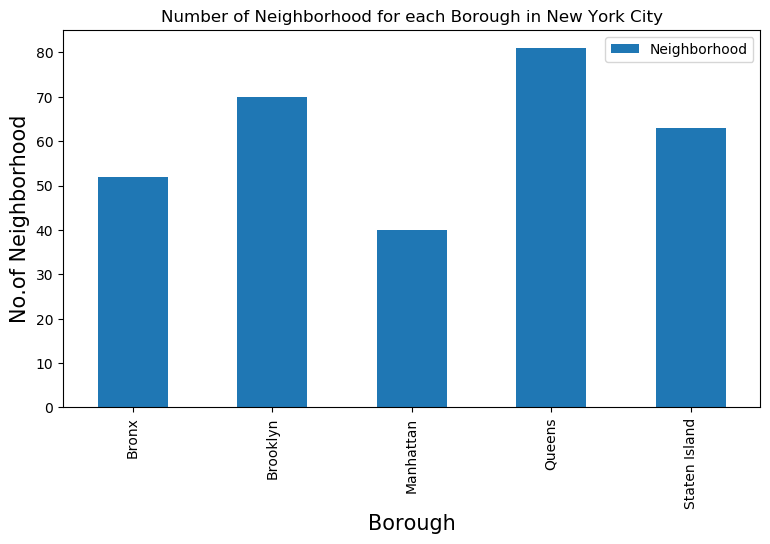

In [85]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### From the above Bar Plot, we can see that Queens has highest number of neighborhoods.

Next we will collect Indian resturants for each Neighborhood.

In [86]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

( 143 / 306 ) Indian Resturants in Maspeth, Queens:0
( 144 / 306 ) Indian Resturants in Ridgewood, Queens:1
( 145 / 306 ) Indian Resturants in Glendale, Queens:0
( 146 / 306 ) Indian Resturants in Rego Park, Queens:1
( 147 / 306 ) Indian Resturants in Woodhaven, Queens:0
( 148 / 306 ) Indian Resturants in Ozone Park, Queens:0
( 149 / 306 ) Indian Resturants in South Ozone Park, Queens:1
( 150 / 306 ) Indian Resturants in College Point, Queens:0
( 151 / 306 ) Indian Resturants in Whitestone, Queens:0
( 152 / 306 ) Indian Resturants in Bayside, Queens:3
( 153 / 306 ) Indian Resturants in Auburndale, Queens:0
( 154 / 306 ) Indian Resturants in Little Neck, Queens:0
( 155 / 306 ) Indian Resturants in Douglaston, Queens:0
( 156 / 306 ) Indian Resturants in Glen Oaks, Queens:4
( 157 / 306 ) Indian Resturants in Bellerose, Queens:0
( 158 / 306 ) Indian Resturants in Kew Gardens Hills, Queens:1
( 159 / 306 ) Indian Resturants in Fresh Meadows, Queens:0
( 160 / 306 ) Indian Resturants in Briarw

( 280 / 306 ) Indian Resturants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) Indian Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Indian Resturants in Weeksville, Brooklyn:0
( 283 / 306 ) Indian Resturants in Broadway Junction, Brooklyn:1
( 284 / 306 ) Indian Resturants in Dumbo, Brooklyn:0
( 285 / 306 ) Indian Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) Indian Resturants in Willowbrook, Staten Island:0
( 287 / 306 ) Indian Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) Indian Resturants in Egbertville, Staten Island:0
( 289 / 306 ) Indian Resturants in Roxbury, Queens:0
( 290 / 306 ) Indian Resturants in Homecrest, Brooklyn:0
( 291 / 306 ) Indian Resturants in Middle Village, Queens:0
( 292 / 306 ) Indian Resturants in Prince's Bay, Staten Island:0
( 293 / 306 ) Indian Resturants in Lighthouse Hill, Staten Island:0
( 294 / 306 ) Indian Resturants in Richmond Valley, Staten Island:0
( 295 / 306 ) Indian Resturants in Malba, Queens:0
( 296 / 306 ) Indian Re

Now that we have got all the indian resturants in new york city , we will analyze it.

In [87]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [88]:
indian_rest_ny.shape

(140, 4)

### From the above result, we see that there are 151 Indian Resturants across New York City.

Now let create a BAR PLOT to show Number of Indian Resturants for each Borough in New York City.

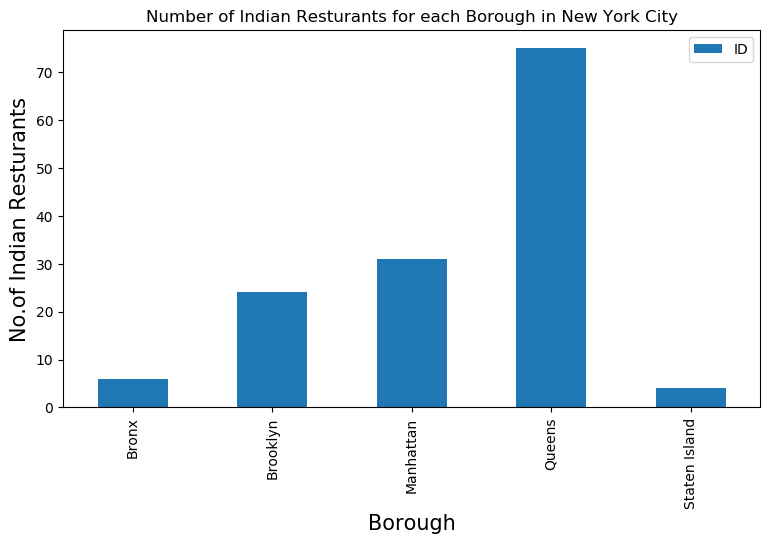

In [89]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### From the above Bar Plot, we can see that Queens has highest number of Indian resturants.

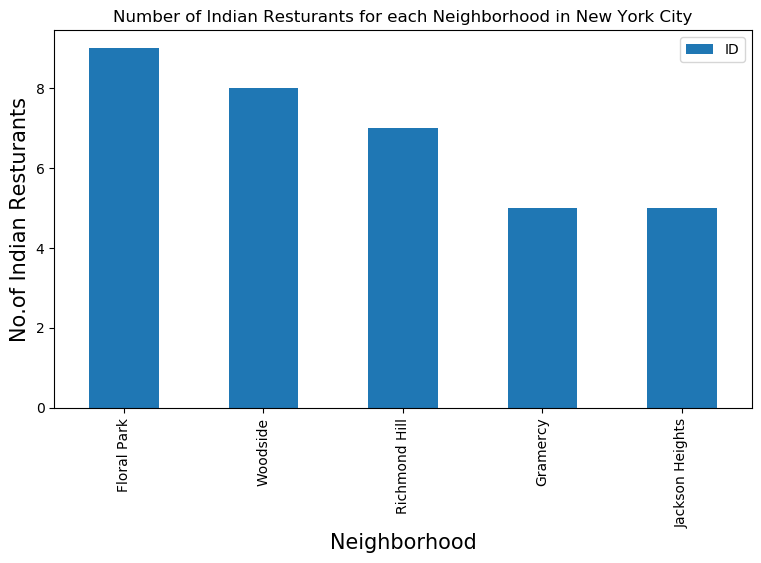

In [90]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [91]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
100,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
101,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
102,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
103,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
104,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
105,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
106,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
107,Queens,Floral Park,55d68c1b498ecf05fa196fe1,Namaste Restaurant and Cafe
108,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


### We can see that, Floral Park in Queens has the highest number of Indian Resturants with a total count of 11.

Now we will get the ranking of each resturant for further analysis.

In [92]:
indian_rest_ny.values.tolist()

[['Bronx', 'Woodlawn', '4c0448d9310fc9b6bf1dc761', 'Curry Spot'],
 ['Bronx',
  'Parkchester',
  '4c194631838020a13e78e561',
  'Melanies Roti Bar And Grill'],
 ['Bronx',
  'Spuyten Duyvil',
  '4c04544df423a593ac83d116',
  'Cumin Indian Cuisine'],
 ['Bronx', 'Concourse', '551b7f75498e86c00a0ed2e1', 'Hungry Bird'],
 ['Bronx',
  'Unionport',
  '4c194631838020a13e78e561',
  'Melanies Roti Bar And Grill'],
 ['Brooklyn', 'Bay Ridge', '4b5a4dc8f964a520a2bb28e3', 'Taj Mahal'],
 ['Brooklyn', 'Bay Ridge', '545835a1498e820edc6f636f', 'Bombay Grill'],
 ['Brooklyn', 'Brighton Beach', '4af0d31bf964a5207ddf21e3', 'Pak Nasheman'],
 ['Brooklyn', 'Flatbush', '52213c4211d295d4c57a607c', 'Ashoka Grill'],
 ['Brooklyn', 'Flatbush', '564d283d498e6e851df79d87', 'Great Indian Curry'],
 ['Brooklyn', 'East Flatbush', '512a9ea9e4b004fb8eeb84e5', 'Silver Krust'],
 ['Brooklyn', 'Kensington', '4db0f4371e729fcc56497f20', 'Mashallah'],
 ['Brooklyn',
  'Kensington',
  '4b718914f964a520c04b2de3',
  'Madina Restaurant and

In [93]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

{'meta': {'code': 200, 'requestId': '5eb3c1d76d8c56001ba99e9c'}, 'response': {'venue': {'id': '4c0448d9310fc9b6bf1dc761', 'name': 'Curry Spot', 'contact': {'phone': '7187085900', 'formattedPhone': '(718) 708-5900'}, 'location': {'address': '4268 Katonah Ave', 'crossStreet': 'E 235 Street', 'lat': 40.897624941880906, 'lng': -73.86714729157393, 'labeledLatLngs': [{'label': 'display', 'lat': 40.897624941880906, 'lng': -73.86714729157393}, {'label': 'entrance', 'lat': 40.897709, 'lng': -73.86707}], 'postalCode': '10470', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4268 Katonah Ave (E 235 Street)', 'Bronx, NY 10470', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/curry-spot/4c0448d9310fc9b6bf1dc761', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 

{'meta': {'code': 200, 'requestId': '5eb3c1e07828ae001bb5b8c6'}, 'response': {'venue': {'id': '4c04544df423a593ac83d116', 'name': 'Cumin Indian Cuisine', 'contact': {}, 'location': {'address': '3549 Johnson Ave', 'lat': 40.886458613786466, 'lng': -73.90981597247142, 'labeledLatLngs': [{'label': 'display', 'lat': 40.886458613786466, 'lng': -73.90981597247142}, {'label': 'entrance', 'lat': 40.886478, 'lng': -73.90987}], 'postalCode': '10463', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3549 Johnson Ave', 'Bronx, NY 10463', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/cumin-indian-cuisine/4c04544df423a593ac83d116', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 9}, 'price': {'tier': 2

{'meta': {'code': 200, 'requestId': '5eb3c2e9df2774001bda6137'}, 'response': {'venue': {'id': '4c194631838020a13e78e561', 'name': 'Melanies Roti Bar And Grill', 'contact': {'phone': '7184091088', 'formattedPhone': '(718) 409-1088'}, 'location': {'address': '1248 Castle Hill Ave', 'crossStreet': 'Newbold Ave', 'lat': 40.833293, 'lng': -73.85104, 'labeledLatLngs': [{'label': 'display', 'lat': 40.833293, 'lng': -73.85104}, {'label': 'entrance', 'lat': 40.833276, 'lng': -73.851166}], 'postalCode': '10462', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1248 Castle Hill Ave (Newbold Ave)', 'Bronx, NY 10462', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/melanies-roti-bar-and-grill/4c194631838020a13e78e561', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.pn

{'meta': {'code': 200, 'requestId': '5eb3c1f8edbcad001bd7bf9c'}, 'response': {'venue': {'id': '545835a1498e820edc6f636f', 'name': 'Bombay Grill', 'contact': {'phone': '7184912500', 'formattedPhone': '(718) 491-2500'}, 'location': {'address': '8716 3rd Ave', 'lat': 40.622371, 'lng': -74.03179899999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.622371, 'lng': -74.03179899999999}, {'label': 'entrance', 'lat': 40.622344, 'lng': -74.031673}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8716 3rd Ave', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bombay-grill/545835a1498e820edc6f636f', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4

{'meta': {'code': 200, 'requestId': '5eb3c1d8ad1ab4001c358fd4'}, 'response': {'venue': {'id': '52213c4211d295d4c57a607c', 'name': 'Ashoka Grill', 'contact': {'phone': '7184341001', 'formattedPhone': '(718) 434-1001'}, 'location': {'address': '1436 Flatbush Ave', 'crossStreet': 'Farragut Avenue', 'lat': 40.635821694890055, 'lng': -73.95081967691863, 'labeledLatLngs': [{'label': 'display', 'lat': 40.635821694890055, 'lng': -73.95081967691863}, {'label': 'entrance', 'lat': 40.635644, 'lng': -73.950869}], 'postalCode': '11210', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1436 Flatbush Ave (Farragut Avenue)', 'Brooklyn, NY 11210', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ashoka-grill/52213c4211d295d4c57a607c', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 

{'meta': {'code': 200, 'requestId': '5eb3c217c8cff2001ca95cc3'}, 'response': {'venue': {'id': '512a9ea9e4b004fb8eeb84e5', 'name': 'Silver Krust', 'contact': {'phone': '7186290010', 'formattedPhone': '(718) 629-0010'}, 'location': {'address': '5253 Avenue D', 'crossStreet': 'E.53rd st', 'lat': 40.64249, 'lng': -73.926862, 'labeledLatLngs': [{'label': 'display', 'lat': 40.64249, 'lng': -73.926862}, {'label': 'entrance', 'lat': 40.64241, 'lng': -73.926689}], 'postalCode': '11203', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5253 Avenue D (E.53rd st)', 'Brooklyn, NY 11203', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/silver-krust/512a9ea9e4b004fb8eeb84e5', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 

{'meta': {'code': 200, 'requestId': '5eb3c06629ce6a001b0eaab1'}, 'response': {'venue': {'id': '4b718914f964a520c04b2de3', 'name': 'Madina Restaurant and Sweets', 'contact': {'phone': '7184693535', 'formattedPhone': '(718) 469-3535'}, 'location': {'address': '563 Coney Island Ave', 'crossStreet': 'Beverly Rd & Lewis Pl', 'lat': 40.64369687020608, 'lng': -73.96999901276827, 'labeledLatLngs': [{'label': 'display', 'lat': 40.64369687020608, 'lng': -73.96999901276827}, {'label': 'entrance', 'lat': 40.643601, 'lng': -73.969868}], 'postalCode': '11218', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['563 Coney Island Ave (Beverly Rd & Lewis Pl)', 'Brooklyn, NY 11218', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/madina-restaurant-and-sweets/4b718914f964a520c04b2de3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https:

{'meta': {'code': 200, 'requestId': '5eb3c25547b43d0023e380b2'}, 'response': {'venue': {'id': '592e1dae345cbe0fc77cf6c9', 'name': 'Diwan Grill', 'contact': {'phone': '7182307852', 'formattedPhone': '(718) 230-7852'}, 'location': {'address': '678 Franklin ave', 'lat': 40.675354999999996, 'lng': -73.95650699999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.675354999999996, 'lng': -73.95650699999999}, {'label': 'entrance', 'lat': 40.675334, 'lng': -73.956411}], 'postalCode': '11238', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['678 Franklin ave', 'Brooklyn, NY 11238', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/diwan-grill/592e1dae345cbe0fc77cf6c9', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False,

{'meta': {'code': 200, 'requestId': '5eb3c2279da7ee001b7783ed'}, 'response': {'venue': {'id': '57596dad498e732300496b23', 'name': 'Dosa Royale', 'contact': {'phone': '7185763800', 'formattedPhone': '(718) 576-3800'}, 'location': {'address': '258 Dekalb Ave', 'lat': 40.689466368706604, 'lng': -73.96870434089776, 'labeledLatLngs': [{'label': 'display', 'lat': 40.689466368706604, 'lng': -73.96870434089776}], 'postalCode': '11205', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['258 Dekalb Ave', 'New York, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dosa-royale/57596dad498e732300496b23', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 22}, 'url': 'http://www.dosaroyale.com', 

{'meta': {'code': 200, 'requestId': '5eb3c1d23907e7001b5f94b2'}, 'response': {'venue': {'id': '57596dad498e732300496b23', 'name': 'Dosa Royale', 'contact': {'phone': '7185763800', 'formattedPhone': '(718) 576-3800'}, 'location': {'address': '258 Dekalb Ave', 'lat': 40.689466368706604, 'lng': -73.96870434089776, 'labeledLatLngs': [{'label': 'display', 'lat': 40.689466368706604, 'lng': -73.96870434089776}], 'postalCode': '11205', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['258 Dekalb Ave', 'New York, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dosa-royale/57596dad498e732300496b23', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 22}, 'url': 'http://www.dosaroyale.com', 

{'meta': {'code': 200, 'requestId': '5eb3c11271c428001b5f658b'}, 'response': {'venue': {'id': '543870ec498ec64de510608d', 'name': 'Masala Grill', 'contact': {}, 'location': {'address': 'Atlantic Avenue', 'crossStreet': '3rd Avenue', 'lat': 40.68554017378092, 'lng': -73.98120188318653, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68554017378092, 'lng': -73.98120188318653}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Atlantic Avenue (3rd Avenue)', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/masala-grill/543870ec498ec64de510608d', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 14}, 'url': 'http://masalagrillbk.com', 'price': {'tie

{'meta': {'code': 200, 'requestId': '5eb3c1ed14a126001b0ace4a'}, 'response': {'venue': {'id': '4bb93b70cf2fc9b6fe64a002', 'name': 'Gandhi Fine Indian Cuisine', 'contact': {'phone': '7182827012', 'formattedPhone': '(718) 282-7012'}, 'location': {'address': '2032 Bedford Ave', 'crossStreet': 'btwn Clarkson Ave & Parkside Ave', 'lat': 40.65516762218564, 'lng': -73.95632450081226, 'labeledLatLngs': [{'label': 'display', 'lat': 40.65516762218564, 'lng': -73.95632450081226}], 'postalCode': '11226', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2032 Bedford Ave (btwn Clarkson Ave & Parkside Ave)', 'Brooklyn, NY 11226', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/gandhi-fine-indian-cuisine/4bb93b70cf2fc9b6fe64a002', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 's

{'meta': {'code': 200, 'requestId': '5eb3c14ea2e538001b8dcd0c'}, 'response': {'venue': {'id': '5539753f498edbace4746b67', 'name': 'Tandoori Masala', 'contact': {'phone': '3473782396', 'formattedPhone': '(347) 378-2396'}, 'location': {'address': '1695 Broadway', 'lat': 40.683978, 'lng': -73.911891, 'labeledLatLngs': [{'label': 'display', 'lat': 40.683978, 'lng': -73.911891}], 'postalCode': '11207', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1695 Broadway', 'Brooklyn, NY 11207', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tandoori-masala/5539753f498edbace4746b67', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'li

{'meta': {'code': 200, 'requestId': '5eb3c223542890001b6bdf20'}, 'response': {'venue': {'id': '519ff6c8498e1300ddcbd45c', 'name': 'Anarkali Indian Cuisine', 'contact': {'phone': '7182822200', 'formattedPhone': '(718) 282-2200'}, 'location': {'address': '1125 Church Ave', 'lat': 40.647488, 'lng': -73.96860500000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.647488, 'lng': -73.96860500000001}, {'label': 'entrance', 'lat': 40.647374, 'lng': -73.968584}], 'postalCode': '11218', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1125 Church Ave', 'Brooklyn, NY 11218', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/anarkali-indian-cuisine/519ff6c8498e1300ddcbd45c', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': Fa

{'meta': {'code': 200, 'requestId': '5eb3c2669fcb92001b2bc256'}, 'response': {'venue': {'id': '545835a1498e820edc6f636f', 'name': 'Bombay Grill', 'contact': {'phone': '7184912500', 'formattedPhone': '(718) 491-2500'}, 'location': {'address': '8716 3rd Ave', 'lat': 40.622371, 'lng': -74.03179899999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.622371, 'lng': -74.03179899999999}, {'label': 'entrance', 'lat': 40.622344, 'lng': -74.031673}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8716 3rd Ave', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bombay-grill/545835a1498e820edc6f636f', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4

{'meta': {'code': 200, 'requestId': '5eb3c0a6aba297001c2f551b'}, 'response': {'venue': {'id': '54c2bd96498eaf5142e3fe92', 'name': 'Clove Indian Restaurant & Bar', 'contact': {'phone': '6469186644', 'formattedPhone': '(646) 918-6644', 'twitter': 'cloveindian'}, 'location': {'address': '1592 Amsterdam Ave', 'crossStreet': 'btwn 139th St & 138th St', 'lat': 40.82128, 'lng': -73.95062, 'labeledLatLngs': [{'label': 'display', 'lat': 40.82128, 'lng': -73.95062}, {'label': 'entrance', 'lat': 40.821289, 'lng': -73.950696}], 'postalCode': '10031', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1592 Amsterdam Ave (btwn 139th St & 138th St)', 'New York, NY 10031', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/clove-indian-restaurant--bar/54c2bd96498eaf5142e3fe92', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4

{'meta': {'code': 200, 'requestId': '5eb3c0b9bae9a2001b5dd093'}, 'response': {'venue': {'id': '5914ff32b23dfa207eca38de', 'name': 'Mumbai Masala', 'contact': {'phone': '2123680100', 'formattedPhone': '(212) 368-0100'}, 'location': {'address': '1768 Amsterdam Ave', 'lat': 40.826928, 'lng': -73.946713, 'labeledLatLngs': [{'label': 'display', 'lat': 40.826928, 'lng': -73.946713}], 'postalCode': '10031', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1768 Amsterdam Ave', 'New York, NY 10031', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mumbai-masala/5914ff32b23dfa207eca38de', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 7}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'

{'meta': {'code': 200, 'requestId': '5eb3bffc02a172001b2ac789'}, 'response': {'venue': {'id': '54c2bd96498eaf5142e3fe92', 'name': 'Clove Indian Restaurant & Bar', 'contact': {'phone': '6469186644', 'formattedPhone': '(646) 918-6644', 'twitter': 'cloveindian'}, 'location': {'address': '1592 Amsterdam Ave', 'crossStreet': 'btwn 139th St & 138th St', 'lat': 40.82128, 'lng': -73.95062, 'labeledLatLngs': [{'label': 'display', 'lat': 40.82128, 'lng': -73.95062}, {'label': 'entrance', 'lat': 40.821289, 'lng': -73.950696}], 'postalCode': '10031', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1592 Amsterdam Ave (btwn 139th St & 138th St)', 'New York, NY 10031', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/clove-indian-restaurant--bar/54c2bd96498eaf5142e3fe92', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4

{'meta': {'code': 200, 'requestId': '5eb3c23d0be7b4001bfbad0a'}, 'response': {'venue': {'id': '56d87f3d498ee215abee5724', 'name': 'Delhi Masala', 'contact': {'phone': '2126668600', 'formattedPhone': '(212) 666-8600'}, 'location': {'address': '2077 Adam Clayton Powell Jr Blvd', 'crossStreet': '124th Street', 'lat': 40.808009000000006, 'lng': -73.948587, 'labeledLatLngs': [{'label': 'display', 'lat': 40.808009000000006, 'lng': -73.948587}], 'postalCode': '10027', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2077 Adam Clayton Powell Jr Blvd (124th Street)', 'New York, NY 10027', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/delhi-masala/56d87f3d498ee215abee5724', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': Fa

{'meta': {'code': 200, 'requestId': '5eb3c299b57e88001b52b181'}, 'response': {'venue': {'id': '54c2bd96498eaf5142e3fe92', 'name': 'Clove Indian Restaurant & Bar', 'contact': {'phone': '6469186644', 'formattedPhone': '(646) 918-6644', 'twitter': 'cloveindian'}, 'location': {'address': '1592 Amsterdam Ave', 'crossStreet': 'btwn 139th St & 138th St', 'lat': 40.82128, 'lng': -73.95062, 'labeledLatLngs': [{'label': 'display', 'lat': 40.82128, 'lng': -73.95062}, {'label': 'entrance', 'lat': 40.821289, 'lng': -73.950696}], 'postalCode': '10031', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1592 Amsterdam Ave (btwn 139th St & 138th St)', 'New York, NY 10031', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/clove-indian-restaurant--bar/54c2bd96498eaf5142e3fe92', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4

{'meta': {'code': 200, 'requestId': '5eb3c0ba660a9f001f851b33'}, 'response': {'venue': {'id': '519fe6f5498e30595d370c44', 'name': 'Bawarchi', 'contact': {'phone': '2122897718', 'formattedPhone': '(212) 289-7718'}, 'location': {'address': '1546 Madison Ave', 'crossStreet': 'Between 104 and 105th', 'lat': 40.792797, 'lng': -73.950383, 'labeledLatLngs': [{'label': 'display', 'lat': 40.792797, 'lng': -73.950383}, {'label': 'entrance', 'lat': 40.79276, 'lng': -73.950291}], 'postalCode': '10029', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1546 Madison Ave (Between 104 and 105th)', 'New York, NY 10029', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bawarchi/519fe6f5498e30595d370c44', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': Tru

{'meta': {'code': 200, 'requestId': '5eb3c211c546f3001cd64449'}, 'response': {'venue': {'id': '56ed855a498ef3bb022352c3', 'name': 'Mughlai Indian Cuisine', 'contact': {'phone': '2127226262', 'formattedPhone': '(212) 722-6262'}, 'location': {'address': '1724 2nd Ave', 'crossStreet': '89th & 90th St', 'lat': 40.78020580283837, 'lng': -73.95008785684102, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78020580283837, 'lng': -73.95008785684102}], 'postalCode': '10128', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1724 2nd Ave (89th & 90th St)', 'New York, NY 10128', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mughlai-indian-cuisine/56ed855a498ef3bb022352c3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': Fals

{'meta': {'code': 200, 'requestId': '5eb3c2416001fe001b63e55a'}, 'response': {'venue': {'id': '4fe4fb50c2eee335e4fea69d', 'name': 'Moti Mahal Delux', 'contact': {'phone': '2123713535', 'formattedPhone': '(212) 371-3535', 'twitter': 'motimahalus', 'facebook': '464790890213866', 'facebookUsername': 'MotiMahalDeluxNYC', 'facebookName': 'Moti Mahal Delux, NYC'}, 'location': {'address': '1149 1st Ave', 'crossStreet': '63rd Street', 'lat': 40.76209761945207, 'lng': -73.96028513480461, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76209761945207, 'lng': -73.96028513480461}, {'label': 'entrance', 'lat': 40.762073, 'lng': -73.960379}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1149 1st Ave (63rd Street)', 'New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/moti-mahal-delux/4fe4fb50c2eee335e4fea69d', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'plura

{'meta': {'code': 200, 'requestId': '5eb3c18de826ac001bd557d3'}, 'response': {'venue': {'id': '42489a80f964a5208b201fe3', 'name': 'Swagat', 'contact': {'phone': '2123621400', 'formattedPhone': '(212) 362-1400', 'twitter': 'swagatny'}, 'location': {'address': '411 Amsterdam Ave', 'crossStreet': 'btwn 80th St & 79th St', 'lat': 40.783573082941615, 'lng': -73.97803042905113, 'labeledLatLngs': [{'label': 'display', 'lat': 40.783573082941615, 'lng': -73.97803042905113}], 'postalCode': '10024', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['411 Amsterdam Ave (btwn 80th St & 79th St)', 'New York, NY 10024', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/swagat/42489a80f964a5208b201fe3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}

{'meta': {'code': 200, 'requestId': '5eb3c307df2774001bda9b0a'}, 'response': {'venue': {'id': '5953e40462420b044e8989f4', 'name': 'indikitch', 'contact': {'phone': '6464819905', 'formattedPhone': '(646) 481-9905', 'twitter': 'indikitch', 'instagram': 'indikitch'}, 'location': {'address': '1190 6th Avenue', 'lat': 40.75768139999999, 'lng': -73.9818088, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75768139999999, 'lng': -73.9818088}], 'postalCode': '10036', 'cc': 'US', 'neighborhood': 'Midtown East', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1190 6th Avenue', 'New York, NY 10036', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/indikitch/5953e40462420b044e8989f4', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 

{'meta': {'code': 200, 'requestId': '5eb3c1ee78a484001bd35613'}, 'response': {'venue': {'id': '4acf6ed7f964a520a0d320e3', 'name': 'Cafe Spice', 'contact': {'phone': '6462271300', 'formattedPhone': '(646) 227-1300', 'twitter': 'cafe_spice'}, 'location': {'address': 'Grand Central Terminal', 'crossStreet': 'Dining Concourse', 'lat': 40.75254204028965, 'lng': -73.97738135881644, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75254204028965, 'lng': -73.97738135881644}], 'postalCode': '10017', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Grand Central Terminal (Dining Concourse)', 'New York, NY 10017', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/cafe-spice/4acf6ed7f964a520a0d320e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary':

{'meta': {'code': 200, 'requestId': '5eb3c190e826ac001bd55e0b'}, 'response': {'venue': {'id': '59fcd48c464d6567ed2f5e37', 'name': 'The Kati Roll Company', 'contact': {'twitter': 'katirollcompany', 'instagram': 'thekatirollcompany', 'facebook': '441448589324542', 'facebookUsername': 'TheKatiRollCompany', 'facebookName': 'The Kati Roll Company'}, 'location': {'address': '685 3rd Ave', 'crossStreet': '43rd Street', 'lat': 40.751755966022706, 'lng': -73.97394374737777, 'labeledLatLngs': [{'label': 'display', 'lat': 40.751755966022706, 'lng': -73.97394374737777}], 'postalCode': '10017', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['685 3rd Ave (43rd Street)', 'New York, NY 10017', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-kati-roll-company/59fcd48c464d6567ed2f5e37', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix

{'meta': {'code': 200, 'requestId': '5eb3c30adf2774001bdaa0ed'}, 'response': {'venue': {'id': '4b4aab62f964a520978c26e3', 'name': 'Dil-e Punjab Deli', 'contact': {'phone': '2126479428', 'formattedPhone': '(212) 647-9428', 'twitter': 'dilepunjabdeli'}, 'location': {'address': '170 9th Ave', 'crossStreet': 'at 21st St', 'lat': 40.74484451009235, 'lng': -74.00252750283143, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74484451009235, 'lng': -74.00252750283143}, {'label': 'entrance', 'lat': 40.744917, 'lng': -74.002266}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['170 9th Ave (at 21st St)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dile-punjab-deli/4b4aab62f964a520978c26e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/f

{'meta': {'code': 200, 'requestId': '5eb3c2789fcb92001b2be4c4'}, 'response': {'venue': {'id': '591794df2be42556988e4a8e', 'name': 'Rahi', 'contact': {'phone': '2123738900', 'formattedPhone': '(212) 373-8900', 'instagram': 'rahinyc', 'facebook': '1285983764842594', 'facebookUsername': 'rahinyc', 'facebookName': 'Rahi'}, 'location': {'address': '60 Greenwich Ave', 'crossStreet': 'Perry St and Greenwich Ave', 'lat': 40.73596784486649, 'lng': -74.00078323150706, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73596784486649, 'lng': -74.00078323150706}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['60 Greenwich Ave (Perry St and Greenwich Ave)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/rahi/591794df2be42556988e4a8e', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'h

{'meta': {'code': 200, 'requestId': '5eb3c21aedbcad001bd80072'}, 'response': {'venue': {'id': '424de080f964a520ae201fe3', 'name': 'Manhattan Valley', 'contact': {'phone': '2122229222', 'formattedPhone': '(212) 222-9222'}, 'location': {'address': '2636 Broadway', 'crossStreet': 'at 100th', 'lat': 40.79710105362881, 'lng': -73.96994256767292, 'labeledLatLngs': [{'label': 'display', 'lat': 40.79710105362881, 'lng': -73.96994256767292}, {'label': 'entrance', 'lat': 40.797016, 'lng': -73.969753}], 'postalCode': '10025', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2636 Broadway (at 100th)', 'New York, NY 10025', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/manhattan-valley/424de080f964a520ae201fe3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'

{'meta': {'code': 200, 'requestId': '5eb3c1241d67cb001b6e1b4f'}, 'response': {'venue': {'id': '538ba1f2498e279098e4210a', 'name': 'Awadh', 'contact': {'phone': '6468613604', 'formattedPhone': '(646) 861-3604', 'twitter': 'awadhnyc'}, 'location': {'address': '2588 Broadway', 'crossStreet': '98 Street', 'lat': 40.79572232174015, 'lng': -73.97103124622318, 'labeledLatLngs': [{'label': 'display', 'lat': 40.79572232174015, 'lng': -73.97103124622318}, {'label': 'entrance', 'lat': 40.795623, 'lng': -73.970764}], 'postalCode': '10025', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2588 Broadway (98 Street)', 'New York, NY 10025', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/awadh/538ba1f2498e279098e4210a', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.p

{'meta': {'code': 200, 'requestId': '5eb3c3045fb726001b60de36'}, 'response': {'venue': {'id': '49c5ad0af964a5201b571fe3', 'name': 'Roti Roll', 'contact': {'phone': '2126661500', 'formattedPhone': '(212) 666-1500'}, 'location': {'address': '994 Amsterdam Ave', 'crossStreet': '109th St', 'lat': 40.802476908363275, 'lng': -73.96429385747197, 'labeledLatLngs': [{'label': 'display', 'lat': 40.802476908363275, 'lng': -73.96429385747197}, {'label': 'entrance', 'lat': 40.802587, 'lng': -73.964354}], 'postalCode': '10025', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['994 Amsterdam Ave (109th St)', 'New York, NY 10025', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/roti-roll/49c5ad0af964a5201b571fe3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, '

{'meta': {'code': 200, 'requestId': '5eb3c2a8b57e88001b52ce90'}, 'response': {'venue': {'id': '49c5ad0af964a5201b571fe3', 'name': 'Roti Roll', 'contact': {'phone': '2126661500', 'formattedPhone': '(212) 666-1500'}, 'location': {'address': '994 Amsterdam Ave', 'crossStreet': '109th St', 'lat': 40.802476908363275, 'lng': -73.96429385747197, 'labeledLatLngs': [{'label': 'display', 'lat': 40.802476908363275, 'lng': -73.96429385747197}, {'label': 'entrance', 'lat': 40.802587, 'lng': -73.964354}], 'postalCode': '10025', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['994 Amsterdam Ave (109th St)', 'New York, NY 10025', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/roti-roll/49c5ad0af964a5201b571fe3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, '

{'meta': {'code': 200, 'requestId': '5eb3c239c8cff2001ca99dc6'}, 'response': {'venue': {'id': '4a70a75bf964a52016d81fe3', 'name': 'Bhatti Indian Grill', 'contact': {'phone': '2126834228', 'formattedPhone': '(212) 683-4228'}, 'location': {'address': '100 Lexington Ave', 'crossStreet': 'at E 27th St', 'lat': 40.74206502425499, 'lng': -73.98298343609093, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74206502425499, 'lng': -73.98298343609093}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['100 Lexington Ave (at E 27th St)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bhatti-indian-grill/4a70a75bf964a52016d81fe3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': True

{'meta': {'code': 200, 'requestId': '5eb3c11895feaf001be6b9e9'}, 'response': {'venue': {'id': '57f7cbbe498edf8f07c7ba83', 'name': 'Sahib', 'contact': {'phone': '6465900994', 'formattedPhone': '(646) 590-0994'}, 'location': {'address': '104 Lexington Ave', 'crossStreet': 'at 27th St', 'lat': 40.74221158817567, 'lng': -73.98287772503384, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74221158817567, 'lng': -73.98287772503384}, {'label': 'entrance', 'lat': 40.742268, 'lng': -73.982891}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['104 Lexington Ave (at 27th St)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sahib/57f7cbbe498edf8f07c7ba83', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primar

{'meta': {'code': 200, 'requestId': '5eb3c2056d8c56001ba9f561'}, 'response': {'venue': {'id': '4a12eb1ff964a52099771fe3', 'name': 'Dhaba', 'contact': {'phone': '2126791284', 'formattedPhone': '(212) 679-1284', 'twitter': 'dhabanyc', 'facebook': '603662103041500', 'facebookUsername': 'dhabanyc', 'facebookName': 'Dhaba Indian Cuisine'}, 'location': {'address': '108 Lexington Ave', 'crossStreet': 'btwn 27th & 28th St.', 'lat': 40.74233843496071, 'lng': -73.98274966362429, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74233843496071, 'lng': -73.98274966362429}, {'label': 'entrance', 'lat': 40.74236, 'lng': -73.982826}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['108 Lexington Ave (btwn 27th & 28th St.)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dhaba/4a12eb1ff964a52099771fe3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 

{'meta': {'code': 200, 'requestId': '5eb3c16ca2e538001b8e04bd'}, 'response': {'venue': {'id': '4fcf82f54fc6ada5874da997', 'name': 'Chote Nawab', 'contact': {'phone': '2126794603', 'formattedPhone': '(212) 679-4603', 'twitter': 'chotenawab2', 'facebook': '600950589992112', 'facebookUsername': 'ChoteNawabNYC', 'facebookName': 'Chote Nawab Fine Indian Cuisine'}, 'location': {'address': '115 Lexington Ave', 'lat': 40.74258451651163, 'lng': -73.98239607093032, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74258451651163, 'lng': -73.98239607093032}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['115 Lexington Ave', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/chote-nawab/4fcf82f54fc6ada5874da997', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/

{'meta': {'code': 200, 'requestId': '5eb3c23dc8cff2001ca9a45d'}, 'response': {'venue': {'id': '43d537d0f964a520402e1fe3', 'name': 'Vatan', 'contact': {'phone': '2126895666', 'formattedPhone': '(212) 689-5666'}, 'location': {'address': '409 3rd Ave', 'crossStreet': 'at 29th', 'lat': 40.74244047116085, 'lng': -73.98046073418793, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74244047116085, 'lng': -73.98046073418793}, {'label': 'entrance', 'lat': 40.742363, 'lng': -73.980374}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['409 3rd Ave (at 29th)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/vatan/43d537d0f964a520402e1fe3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verif

{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5eb3c1cfb9a389001b04276b'}, 'response': {}}


KeyError: 'venue'

Above function was called with intervals because 50 calls limit is there. Now that we got data for all resturants. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required.

In [95]:
#indian_rest_stats_ny.to_csv('indian_rest_stats_ny_50.csv', index=False)
#indian_rest_stats_ny

Lets verify the data from saved csv file.

In [122]:
indian_rest_stats_ny=pd.read_csv('indian_rest_stats_ny.csv')

In [123]:
indian_rest_stats_ny.shape

(151, 7)

In [124]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.6,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,5.8,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.1,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.9,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,5.8,2


In [125]:

indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       151 non-null    object 
 1   Neighborhood  151 non-null    object 
 2   ID            151 non-null    object 
 3   Name          151 non-null    object 
 4   Likes         151 non-null    int64  
 5   Rating        151 non-null    float64
 6   Tips          151 non-null    int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 8.4+ KB


The Data type of 'Likes' and  'Tips' are of type 'String'. we will convert them into type 'Float' for further analysis.

In [126]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [127]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       151 non-null    object 
 1   Neighborhood  151 non-null    object 
 2   ID            151 non-null    object 
 3   Name          151 non-null    object 
 4   Likes         151 non-null    float64
 5   Rating        151 non-null    float64
 6   Tips          151 non-null    float64
dtypes: float64(3), object(4)
memory usage: 8.4+ KB


Now we will find the Indian restuarants with Maximum Likes, Maximum Ratings and Maximum Tips.

In [128]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                837
Rating                               8.8
Tips                                 260
Name: 37, dtype: object

In [129]:
# Resturant with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                589
Rating                               9.1
Tips                                 146
Name: 40, dtype: object

In [130]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                837
Rating                               8.8
Tips                                 260
Name: 37, dtype: object

Next lets visualize neighborhood with maximum average rating of resturants.

In [131]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [132]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
12,Civic Center,9.100000
69,Tribeca,9.100000
0,Astoria,9.000000
5,Blissville,9.000000
75,West Village,8.800000
44,Midtown South,8.800000
43,Midtown,8.800000
29,Gramercy,8.733333
25,Fort Greene,8.700000
11,Chelsea,8.700000


### Above are the top neighborhoods with top average rating of Indian resturants.

Similarly we will find the average rating of Indian Resturants for each Borough.

In [133]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [134]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.210000
1,Brooklyn,7.700000
3,Queens,6.552113
0,Bronx,5.585714
4,Staten Island,3.533333


Lets Visualize it.

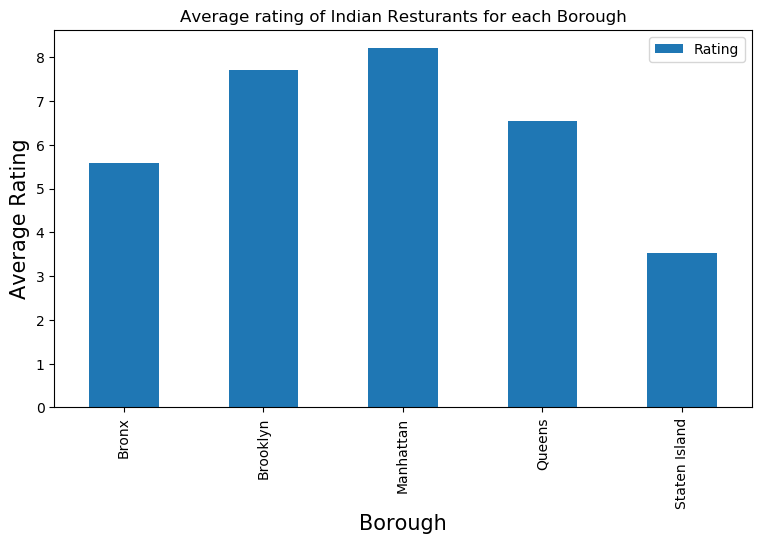

In [135]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map.

In [136]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [137]:
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Astoria,9.0
5,Blissville,9.0
12,Civic Center,9.1
69,Tribeca,9.1


We will join this dataset to original new york data to get lonitude and latitude.

In [138]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [139]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [140]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Astoria,40.768509,-73.915654,9.0
1,Queens,Blissville,40.737251,-73.932442,9.0
2,Manhattan,Civic Center,40.715229,-74.005415,9.1
3,Manhattan,Tribeca,40.721522,-74.010683,9.1


Finally, Let's show this data on a map.

In [141]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [142]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose.

In [143]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [144]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Now that we have visualized the Neighborhoods.
Lets Visualize Boroughs based on average Rating.

In [147]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough_Boundaries.geojson'

map = ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_ratings.html')

# Conclusion:

### So now we can answer the questions asked above in the Questions section of the notebook.
### From our anaysis the answers to the above questions are:

#### A1) Astoria(Queens), Blissville(Queens), Civic Center(Manhattan) are some of the best neighborhoods for Indian cuisine.
#### A2) Manhattan have potential Indian Resturant Market.
#### A3) Staten Island ranks last in average rating of Indian Resturants.
#### A4) Manhattan is the best place to stay if you prefer Indian Cuisine.